## Library Import

In [1]:
# Data Viz. 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
import seaborn as sns
# sns.set_palette(palette='deep')
# sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from sklearn.linear_model import LinearRegression

## Data load and plot

In [2]:
df = pd.read_csv("backprop.csv")                  
df.head()

,x,y
0,-5.00000,0.006693
1,-4.98999,0.006760
2,-4.97998,0.006827
3,-4.96997,0.006895
4,-4.95996,0.006964


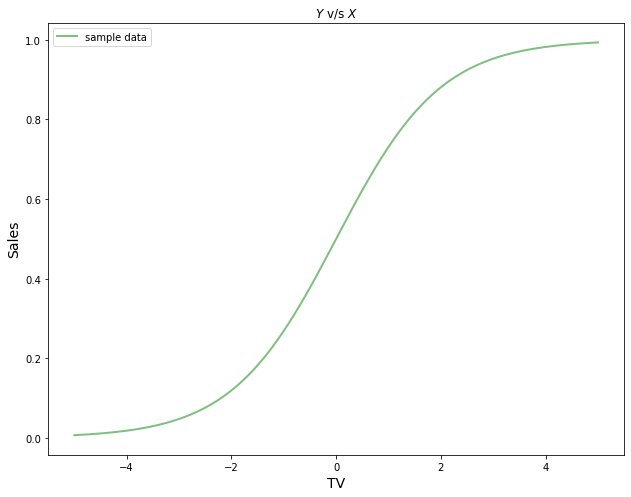

In [3]:
X_data = df.iloc[:,0]
y_data = df.iloc[:,1]
plt.figure(figsize=(4,6))
plt.plot(X_data, y_data,color='g' , lw=2,alpha = 0.5, label='sample data')
plt.title('$Y$ v/s $X$'); 
plt.xlabel('TV',fontsize=14); 
plt.ylabel('Sales',fontsize=14)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()
plt.show()

## Baseline neural network regression

In [4]:
import tensorflow as tf

In [5]:
Sequential = tf.keras.models.Sequential
Dense = tf.keras.layers.Dense

In [6]:
# Early Stop to get a good starting point
model = Sequential(name = 'Basic')
model.add(Dense(2,input_shape = (1,),activation = tf.sin,use_bias=False))
model.add(Dense(1, activation = tf.sin))
model.summary()

Model: "Basic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 2         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(loss='mse',optimizer = 'adam')

In [8]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model.fit(X_data,y_data,validation_split=0.2,callbacks=[callback],epochs=500,verbose=0)

In [9]:
len(model.history.history['val_loss'])

185

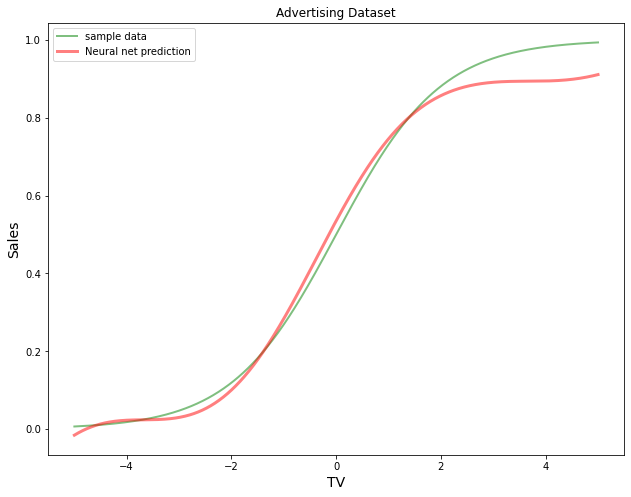

In [10]:
plt.figure(figsize=(4,6))
plt.plot(X_data, y_data,color='g' ,lw=2, alpha = 0.5, label='sample data')
plt.plot(X_data, model.predict(X_data),color='r',lw=3, alpha = 0.5, label='Neural net prediction')
plt.title('Advertising Dataset'); 
plt.xlabel('TV',fontsize=14); 
plt.ylabel('Sales',fontsize=14)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()
plt.show()

In [11]:

w11_start, w12_start = model.layers[0].get_weights()[0].squeeze()
w21_start, w22_start = model.layers[1].get_weights()[0].squeeze()
b1_start = model.layers[1].get_weights()[1].item(0)


## TFP method

### Convert data 

In [12]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [13]:
# Set seed.
tf.random.set_seed(42)
# Set tensor numeric type.
dtype = 'float32'

In [14]:
x = tf.convert_to_tensor(X_data, dtype=dtype)
x = tf.reshape(x,(-1,1))
y = tf.convert_to_tensor(y_data, dtype=dtype)
y = tf.reshape(y, (-1, 1))

## Make Bayesian random variables 

In [15]:
# Input x
# Hidden layer with two activations
# Output with bias
# Total weights = 5
def basic_nn(w1,w2,b2):
    h1 = tf.matmul(x,w1)
    a1 = tf.math.sin(h1)
    h2 = tf.matmul(a1,w2) + b2
    y = tf.math.sin(h2)
    return y

In [16]:
# Model definition
model = tfd.JointDistributionNamedAutoBatched(dict(

    bias=tfd.Normal(
        loc=[tf.cast(b1_start, dtype)], 
        scale=[tf.cast(1.0, dtype)]
    ),
    
    weights1 = tfd.Normal(
    loc=[[tf.cast(w11_start, dtype),tf.cast(w12_start,dtype)]], 
    scale=[[tf.cast(1.0, dtype),tf.cast(5.0,dtype)]]
    ),

    weights2=tfd.Normal(
    loc=[[tf.cast(w21_start, dtype)], [tf.cast(w21_start, dtype)]], 
    scale=[[tf.cast(1.0, dtype)], [tf.cast(5.0, dtype)]]
    ),
    
 

    y= lambda weights1,weights2,bias: 
        tfd.Normal(
            loc=basic_nn(weights1,weights2,bias), 
            scale=1
        ) 
))

def target_log_prob_fn(weights1=None, weights2=None,bias=None):
    return model.log_prob(weights1=weights1,weights2=weights2, bias=bias, y=y)

In [17]:
# Size of each chain.
num_results = int(1e4)
# Burn-in steps.`
num_burnin_steps = int(3e4)
# Hamiltonian Monte Carlo transition kernel. 
# In TFP a TransitionKernel returns a new state given some old state.
hcm_kernel  = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=target_log_prob_fn,
  step_size=1.0,
  num_leapfrog_steps=3
  
)

# This adapts the inner kernel's step_size.
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
  inner_kernel = hcm_kernel,
  num_adaptation_steps=int(num_burnin_steps * 0.8)
)

# Run the chain (with burn-in).
@tf.function
def run_chain():
  # Run the chain (with burn-in). 
  # Implements MCMC via repeated TransitionKernel steps.
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          tf.convert_to_tensor([[w11_start,w21_start]], dtype=dtype),
          tf.convert_to_tensor([[w21_start],[w22_start]], dtype=dtype),
          tf.convert_to_tensor([b1_start], dtype=dtype), 
      ],
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted
    )
  return samples,is_accepted

In [18]:
this,that= run_chain()

In [19]:
chains = [i[that] for i in this]

## Single chain analysis 

In [20]:
# Creating a pandas dataframe with the betas
chains_df = pd.concat(
    objs=[pd.DataFrame(samples.numpy().squeeze()) for samples in chains], 
    axis=1
)
params = ['w11','w12','w21','w22','b1']
chains_df.columns = params

In [21]:
# Creating a sample_id (which is 0-10500)
# Then creating chain_sample_id(rolling from 0-35000)
# Then creating chain_id (c_1 or c_2 or c_3)
chains_df = chains_df \
    .assign(
        sample_id=lambda x: range(x.shape[0]), 
        chain_sample_id=lambda x: x['sample_id'] % num_results,
        chain_id=lambda x: (x['sample_id'] / num_results).astype(int) + 1
    ) \
    .assign(chain_id=lambda x: 'c_' + x['chain_id'].astype(str)) \
    
chains_df.head()

,w11,w12,w21,w22,b1,sample_id,chain_sample_id,chain_id
0,-0.472409,-0.458959,-0.334786,-0.191266,0.566693,0,0,c_1
1,-0.361763,-0.452046,-0.618135,-0.196565,0.683226,1,1,c_1
2,-0.447297,-0.366087,-0.567314,0.104518,0.527812,2,2,c_1
3,-0.330636,-0.447332,-0.694285,-0.063214,0.719451,3,3,c_1
4,-0.268173,-0.683242,-0.454885,-0.242312,0.486442,4,4,c_1


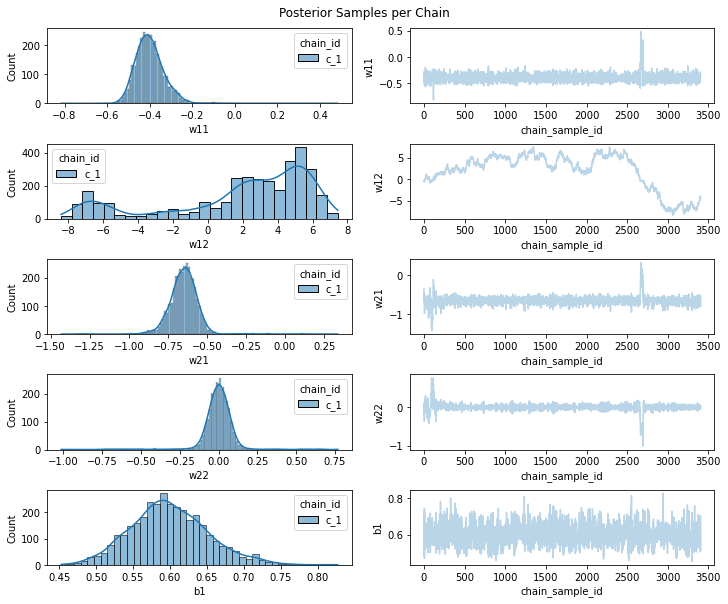

In [22]:
# Plotting
fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(10, 8), constrained_layout=True)

# Plotting for each parameter
for i, param in enumerate(params):
    sns.histplot(x=param, data=chains_df, hue='chain_id', kde=True, ax=axes[i][0])
    sns.lineplot(x='chain_sample_id', y=param, data=chains_df, hue='chain_id', alpha=0.3, legend=False, ax=axes[i][1])

fig.suptitle('Posterior Samples per Chain', y=1.03);

## In-sample predictions

In [23]:
chains_df.head()

,w11,w12,w21,w22,b1,sample_id,chain_sample_id,chain_id
0,-0.472409,-0.458959,-0.334786,-0.191266,0.566693,0,0,c_1
1,-0.361763,-0.452046,-0.618135,-0.196565,0.683226,1,1,c_1
2,-0.447297,-0.366087,-0.567314,0.104518,0.527812,2,2,c_1
3,-0.330636,-0.447332,-0.694285,-0.063214,0.719451,3,3,c_1
4,-0.268173,-0.683242,-0.454885,-0.242312,0.486442,4,4,c_1


In [24]:
y_preds = chains_df.apply(lambda x: basic_nn([[x.w11,x.w12]],[[x.w21],[x.w22]],x.b1),axis=1)

In [25]:
import numpy as np
y_numpreds = np.array([i.numpy() for i in y_preds])

In [26]:
y_bayesian_means = y_numpreds.squeeze().mean(axis=0)#.reshape(-1,1)
y_bayesian_stds = y_numpreds.squeeze().std(axis=0)#.reshape(-1,1)

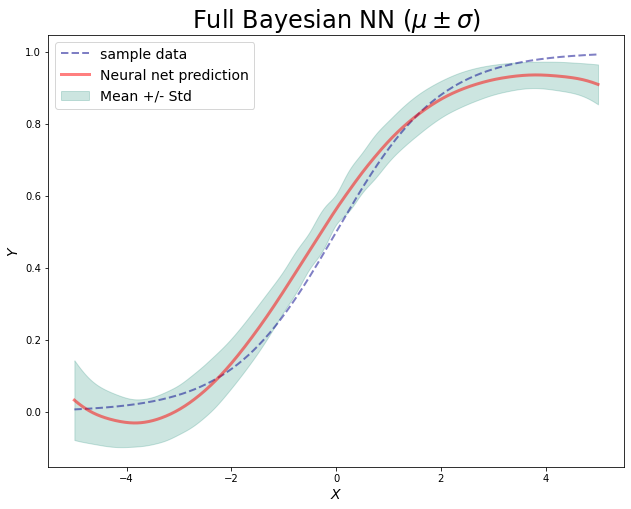

In [27]:
plt.figure(figsize=(4,6))
plt.plot(X_data, y_data,'--',color='darkblue' ,lw=2, alpha = 0.5, label='sample data')
plt.plot(X_data, y_bayesian_means,color='r',lw=3, alpha = 0.5, label='Neural net prediction')
plt.fill_between(X_data, y_bayesian_means+y_bayesian_stds, y_bayesian_means-y_bayesian_stds, color="#007D66", \
                alpha=0.2,label = 'Mean +/- Std')
# ax.fill_between(t, mu2+sigma2, mu2-sigma2, facecolor='yellow', alpha=0.5)
plt.title('Full Bayesian NN ($\mu \pm \sigma$)',fontsize=24); 
plt.xlabel('$X$',fontsize=14); 
plt.ylabel('$Y$',fontsize=14)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend(fontsize=14)
plt.show()

![Fin](https://media.giphy.com/media/jc1dl9ywZPryw/giphy.gif)